[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MouseLand/course-materials/blob/main/behavior_encoding/tutorial.ipynb)


# Behavioral encoding models of neural population activity

In this notebook, we will build several encoding models of neural activity based on the orofacial behaviors of mice.
The encoding models are increasingly more complicated:
1) linear regression from spatial keypoints
2) linear regression from spatiotemporal keypoints
3) nonlinear regression (i.e. neural networks) from spatiotemporal keypoints

We will use rastermap to visualize the neural activity, and also to visualize the prediction.

To keep the notebook interactive, there are three types of exercises throughout

1) QUESTION MARKS: where ????? need to be replaced by a short equation, such as a variable or a function name.
2) DISCUSSION: have a short discussion with your colleague about this. At the end of each section,
we will open the discussions to the whole group.
3) QUIZ:  multiple-choice that we take across the entire group. Keep track of your own points.

**Recording info**: We will use a spontaneous activity recording from [Syeda et al, 2023](https://www.biorxiv.org/content/10.1101/2022.11.03.515121v1.abstract). We recorded 34,086 neurons from mouse sensorimotor cortex for 2+ hours using two-photon calcium imaging at a rate of 3.2Hz. FYI to make the download of the dataset faster, we are analyzing only the first half of the recording. During the recording, the mouse was free to run on an air floating ball, and we recorded the mouse face with a camera at a rate of 50Hz and tracked keypoints on the mouse face.

**Setup**: First we will install the required packages, if not already installed. If on google colab, it will require you to click the "**RESTART RUNTIME**" button because we are updating numpy. Also if you are on google colab, select the GPU runtime:
**Runtime > Change runtime type > Hardware accelerator = GPU**

In [1]:
!pip install numpy>=1.24 # (required for google colab)
!pip install rastermap
!pip install matplotlib
!pip install neuropop

# SUGGESTION: you can hide the ouput of a code cell after running it, by double-clicking on left of the output
# SUGGESTION #2: you can instead run the pip install commands in a different anaconda prompt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

# 1. Loading and preparing.

Import the Python libraries

In [23]:
# general libraries
import os # os stands for "operating system" and includes read/write routines etc.
import numpy as np # by far the most used library for everyday computation
from scipy import stats # here we import a whole sub-library of stats functions
from matplotlib import pyplot as plt # all of our plotting is done with plt
%matplotlib inline
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython

# import rastermap
from rastermap import utils, Rastermap

# download the spontaneous activity recording
filename = utils.download_data(data_type="spont2")

# load the neural data and the processed behavioral data
dat = np.load(filename)

# unpack the dictionary into individual variables: spks = deconvolved fluorescence;
spks = dat["spks"]

# xpos and ypos and position of the neuron in the brain tissue
xpos, ypos = dat["xpos"], dat["ypos"]

# tcam and tneural are times when the video and neural data were sampled, respectively
tcam, tneural = dat["tcam"], dat["tneural"]

# run is the running trace
run = dat["run"][:spks.shape[1]]

# beh are orofacial behavior, beh_names are the names of these orofacial behaviors
beh, beh_names = dat["beh"], dat["beh_names"]

n_neurons, n_time = spks.shape

print(f"{n_neurons} neurons by {n_time} timepoints")


array([0.50479683, 0.33259847, 0.42720176, ..., 0.11712362, 0.57044159,
       0.61772266])

In [6]:
# use this empty cell to inspect properties of various variables, like their shapes or names
# you can always add a new cell using the "+" button at the top of a jupyter notebook
# or with the "+ Code" button above/below a cell

# inspect beh_names for example
print(beh_names)
np.shape(beh_names)

print(beh)
np.shape(beh)

print(run)


[0.50479683 0.33259847 0.42720176 ... 0.11712362 0.57044159 0.61772266]


Data z-scored


(0.9, 1.1)

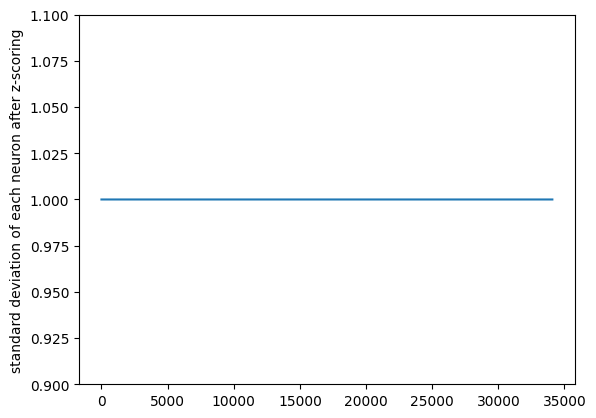

In [11]:
from rastermap.cluster import zscore
# we will z-score each neuron so that the activity is standard deviation 1 and mean 0 for each neuron

# REPLACE ????? with the correct function from a package that we already imported (google is your friend)
spks = zscore(spks, axis=1)

print("Data z-scored")

# colors for the behaviors
kp_colors = np.array([[0.55,0.55,0.55], [0.,0.,1],
                      [0.8,0,0], [1.,0.4,0.2],
                      [0,0.6,0.4], [0.2,1,0.5],
                      ])


plt.plot(spks.std(axis=1))
plt.ylabel('standard deviation of each neuron after z-scoring')
plt.ylim([0.9, 1.1])

# 2. Visualizing neural activity with Rastermap

Let's first look at the positions of the neurons.

(-350.6, 5269.666666666666, -246.13333333333335, 5374.133333333333)

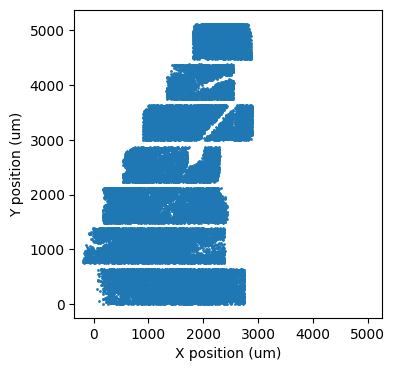

In [12]:
# POSITIONS OF ALL NEURONS
plt.figure(figsize=(4, 4))
plt.scatter(ypos, xpos, c=,s = 1)
plt.xlabel('X position (um)')
plt.ylabel('Y position (um)')
plt.axis("square")

Now let's run Rastermap. Rastermap re-arranges neurons in the raster plot based on similarity of activity.

In [13]:
from rastermap import Rastermap

### run rastermap
model = Rastermap(n_clusters=100, n_PCs=128, locality=0.6,
                  time_lag_window=5).fit(spks)
cc_nodes = model.cc.copy()

# isort contains the neuron indices re-ordered by rastermap
isort = model.isort

# embedding is the embedding position for each neuron from rastermap
embedding = model.embedding[:,0]

normalizing data across axis=1
projecting out mean along axis=0
data normalized, 6.68sec
sorting activity: 34086 valid samples by 14000 timepoints
n_PCs = 128 computed, 42.70sec
100 clusters computed, time 51.47sec
clusters sorted, time 117.87sec
clusters upsampled, time 118.67sec
rastermap complete, time 118.69sec


Let's create superneurons from Rastermap: sort the data and then sum over neighboring neurons.

In [21]:
nbin = 200 # number of neurons to bin over
ndiv = (n_neurons//nbin) * nbin #maximum number of neurons that is a multiple of nbin

# REPLACE ????? with the re-ordering of the rows of the neural activity matrix using the sorting from Rastermap
sn = spks[isort]

# group sorted matrix into rows of length nbin
sn = sn[:ndiv].reshape(ndiv//nbin, nbin, -1)

print(sn.shape)

# take mean over neurons in a bin
sn = sn.mean(axis=1)

print(sn.shape)

(170, 200, 14000)
(170, 14000)


Let's visualize the activity

(14000,)

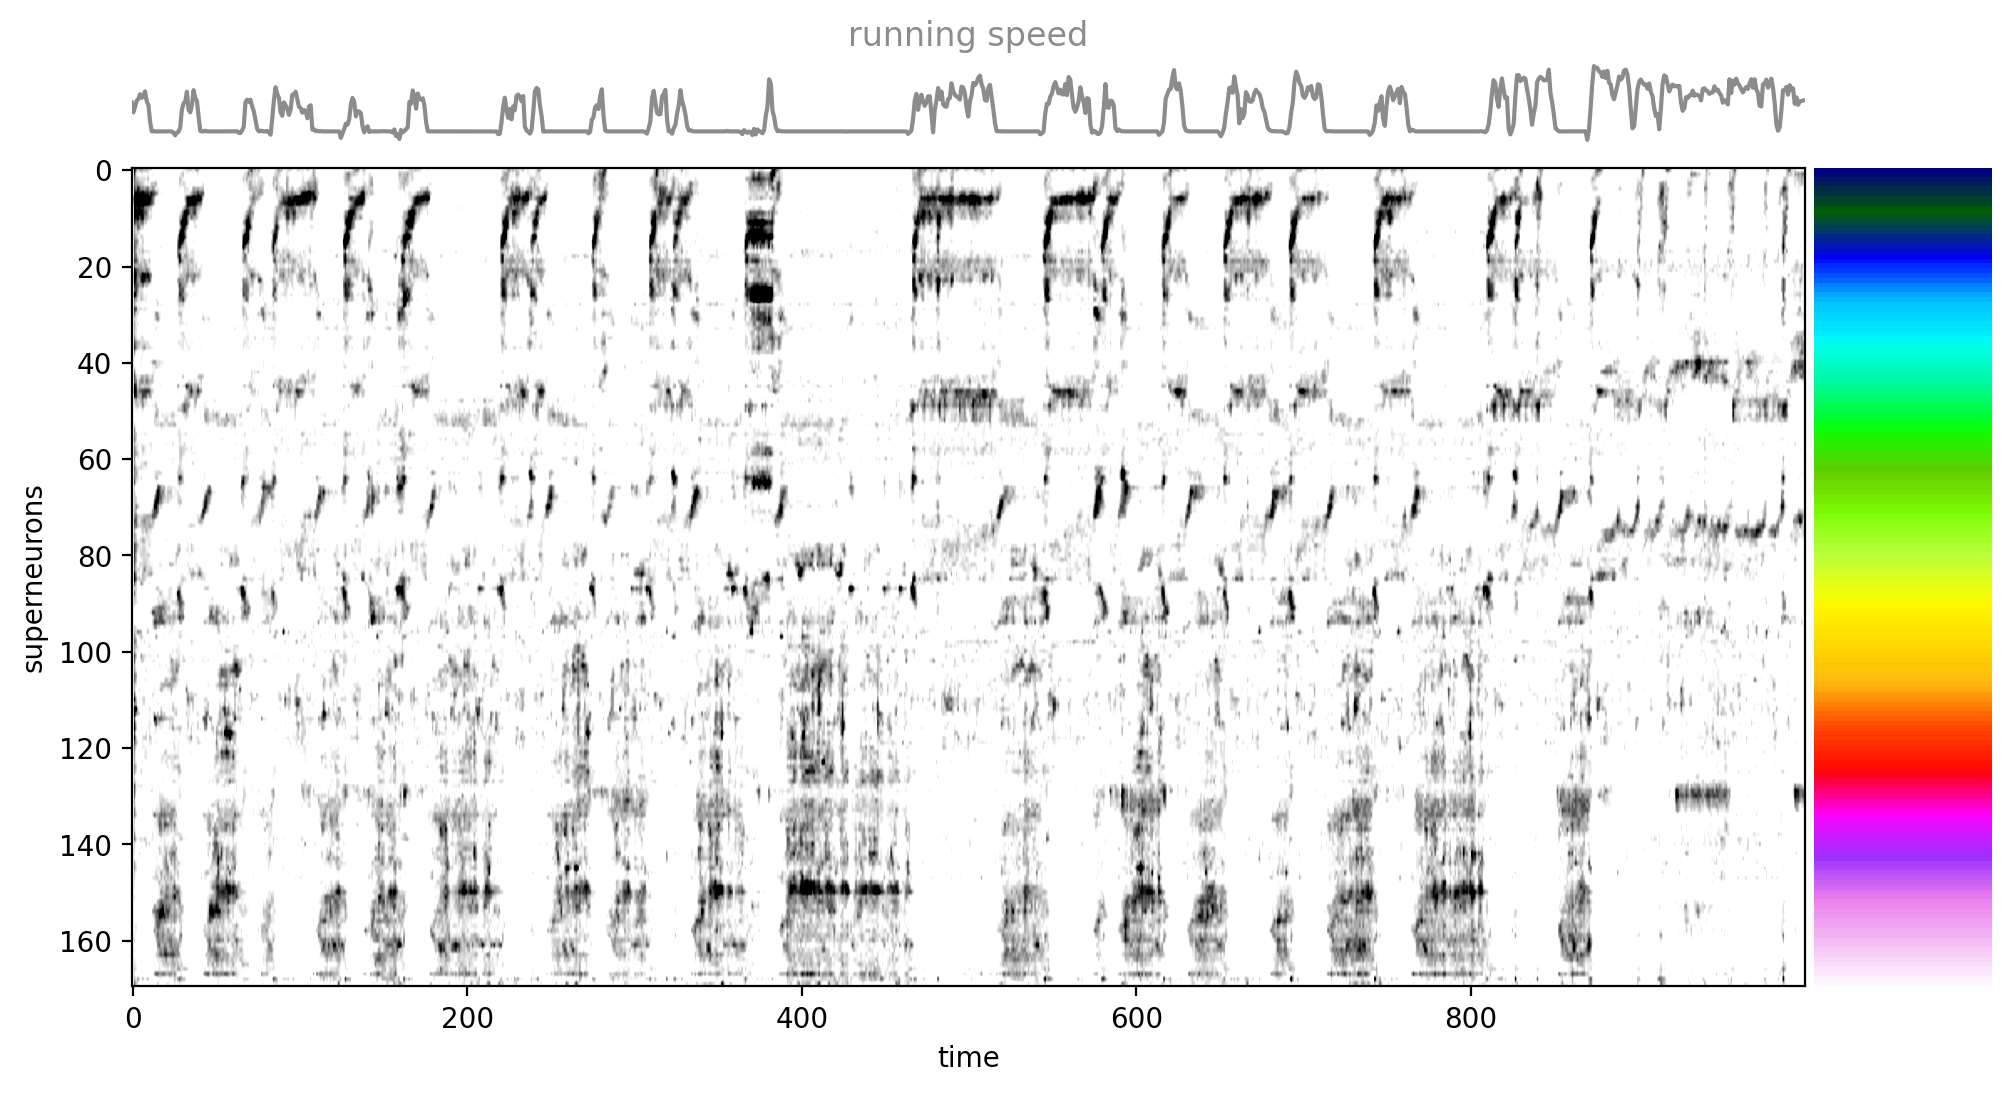

In [30]:
# timepoints to visualize
xmin = 0  # YOU can change this number
xmax = xmin + 1000

fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 10, figure=fig, wspace = 0.05, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[0, :-1])

# replace ????? with the running speed in the interval xmin to xmax
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:, :-1])
# replace ????? with the sorted and binned neural activity in the interval xmin to xmax
ax.imshow(sn[:,xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

ax = plt.subplot(grid[1:, -1])
ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
ax.axis("off")

np.shape(run)

In [ ]:
# DISCUSSION (with a colleague):

# Approximately how many dimensions of neural activity do you think are in the data based on this plot? 3-5? I am thinking just visually based on how many obvious clusters there are...

color the neurons by their position in the rastermap

(-350.6, 5269.666666666666, -246.13333333333335, 5374.133333333333)

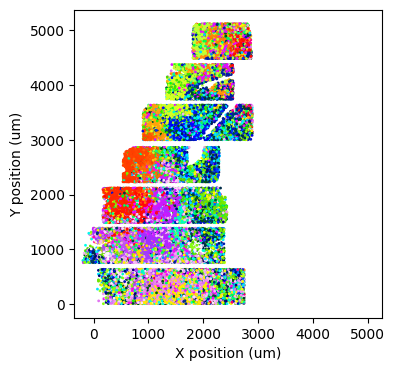

In [31]:
# color the neurons by their position in the rastermap

# POSITIONS OF ALL NEURONS
plt.figure(figsize=(4, 4))

# color the neurons in this plot with c = ?????, where ???? is the embedding position of each neuron from the Rastermap model
plt.scatter(ypos, xpos, s=1, c=embedding, cmap="gist_ncar")
plt.xlabel('X position (um)')
plt.ylabel('Y position (um)')
plt.axis("square")

# 3. Dimensionality reduction: what are the dominant patterns of activity?

Let's compute the top PCs

In [38]:
from sklearn.decomposition import TruncatedSVD
np.shape(spks)
# this function returns the left singular vectors scaled by the singular values
Vsv = TruncatedSVD(n_components = 128).fit_transform(spks.T)

# REPLACE ????? to normalize the singular vectors to unit norm (across time)
V = Vsv.copy() / (len(spks[1,:]))

# project the spiking data onto the singular vectors
U = spks @ V

# renormalize the neural projections
U /= (U**2).sum(axis=0)**0.5


array([[ 0.01169635, -0.0013643 , -0.00771963, ...,  0.00273431,
        -0.0022698 ,  0.00712012],
       [-0.00931378, -0.00894025,  0.01676363, ...,  0.01502537,
         0.00133386, -0.00162971],
       [-0.00988266,  0.00731853,  0.01785561, ..., -0.00941833,
        -0.00200869, -0.00800331],
       ...,
       [ 0.00135295, -0.00094798, -0.00267813, ..., -0.00296735,
         0.00342239,  0.00394725],
       [ 0.00250312, -0.00221674, -0.00501521, ...,  0.00441548,
         0.0104638 , -0.00432656],
       [ 0.00335125, -0.00088518, -0.00269218, ...,  0.00571525,
         0.0056424 , -0.00380187]], dtype=float32)

In [43]:
# QUIZ, answer A, B or C:
np.shape(U)
# How to obtain the singular values of the data from the U matrix:
# A) take the column norms of U (I believe A, cause columns are the computed vectors)
# B) take the row norms of U
# C) it cannot be obtained from U (it was C)

(34086, 128)

plot the PCs in time

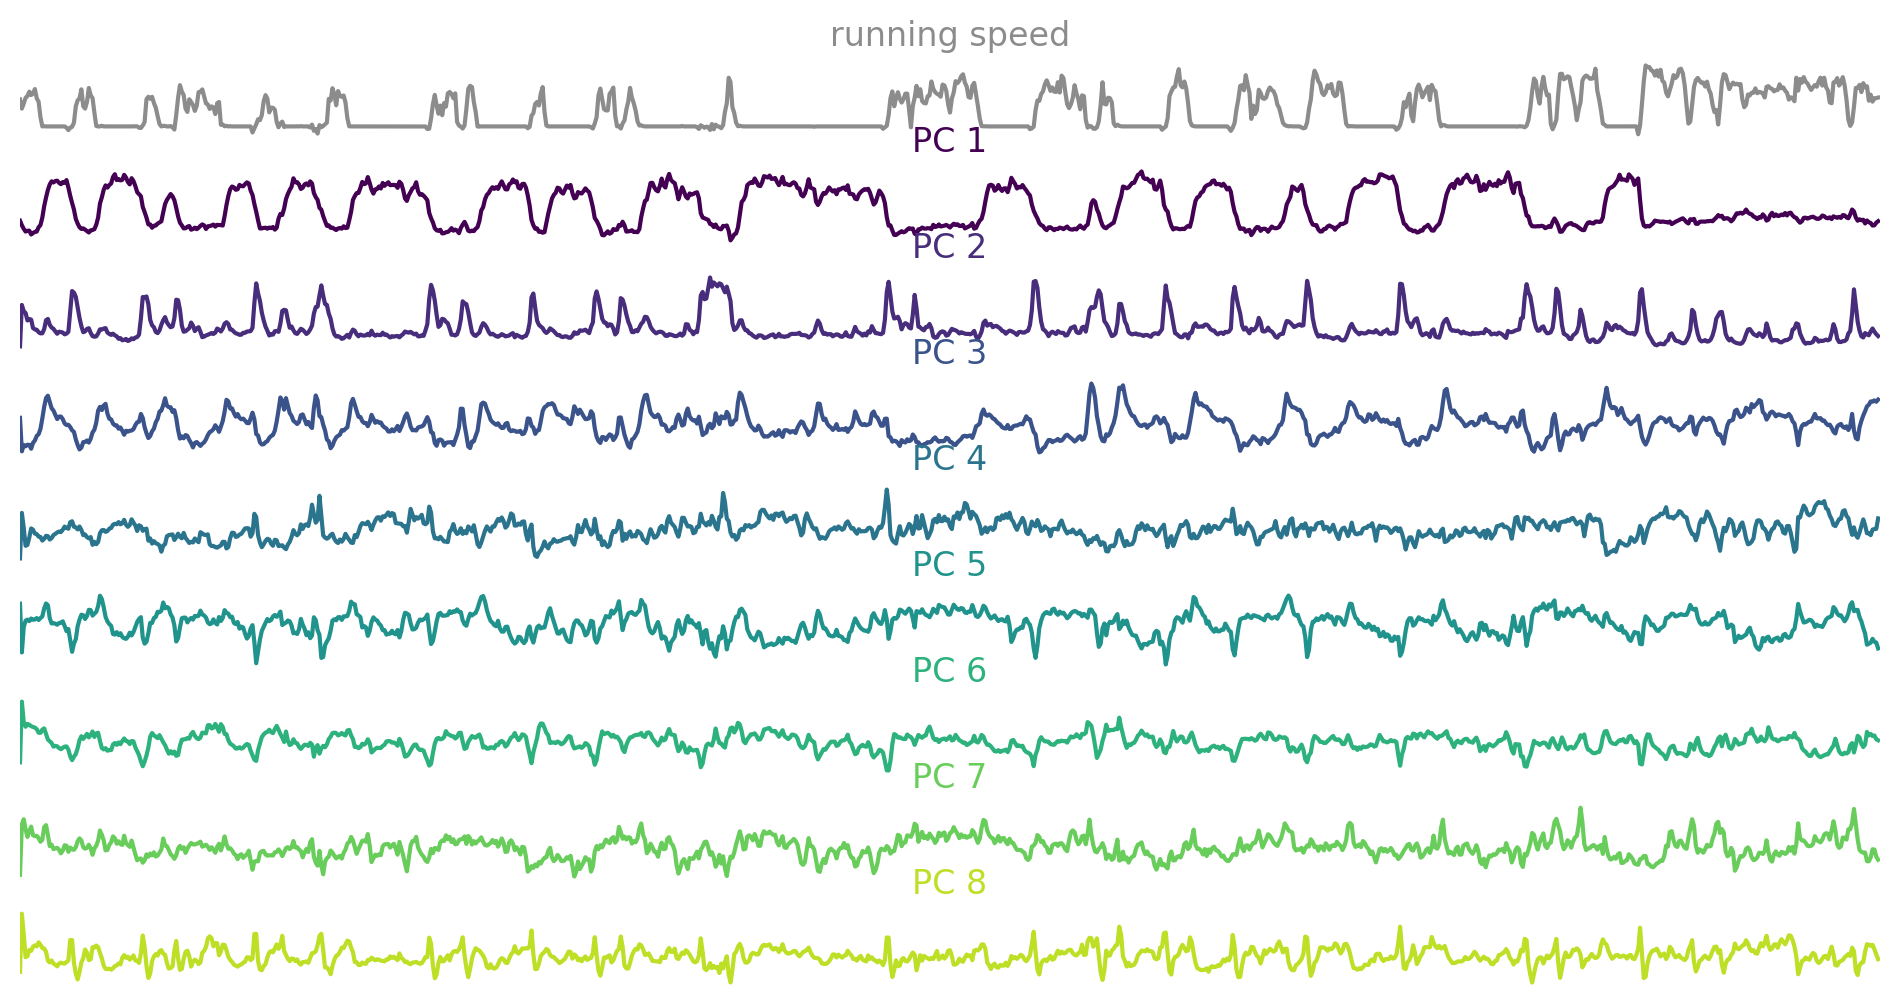

In [40]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 1, figure=fig, hspace = 0.4)

# plot running speed
ax = plt.subplot(grid[0, 0])
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

pc_colors = plt.get_cmap("viridis")(np.linspace(0,0.9,8))
for j in range(8):
    ax = plt.subplot(grid[j+1])
    ax.plot(Vsv[xmin:xmax, j], color=pc_colors[j])
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}", color=pc_colors[j])


Text(0, 0.5, 'PC2')

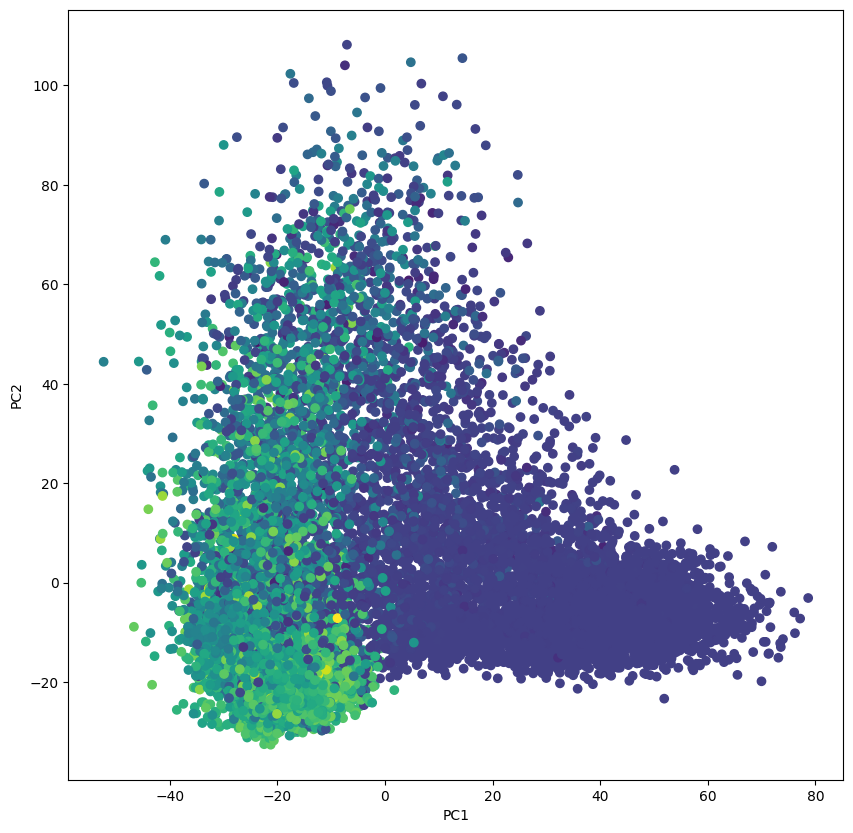

In [52]:
# Make a scatter plot of PC1 vs PC2 across all timepoints.
# Color the points by running speed. Do you see any structure?
np.shape(Vsv)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
# REPLACE ????? with PC1 and PC2
ax.scatter(Vsv[:,0], Vsv[:,1], c=run, cmap = 'viridis')

plt.xlabel('PC1')
plt.ylabel('PC2')

we will predict the PCs from the behavior (many fewer of them)

# 4. Behavioral analysis



We will figure out the sorts of behaviors the superneurons care about!

The behavioral video is at 50Hz while the neural data is at 3.2 Hz.

Here are the behaviors we tracked:

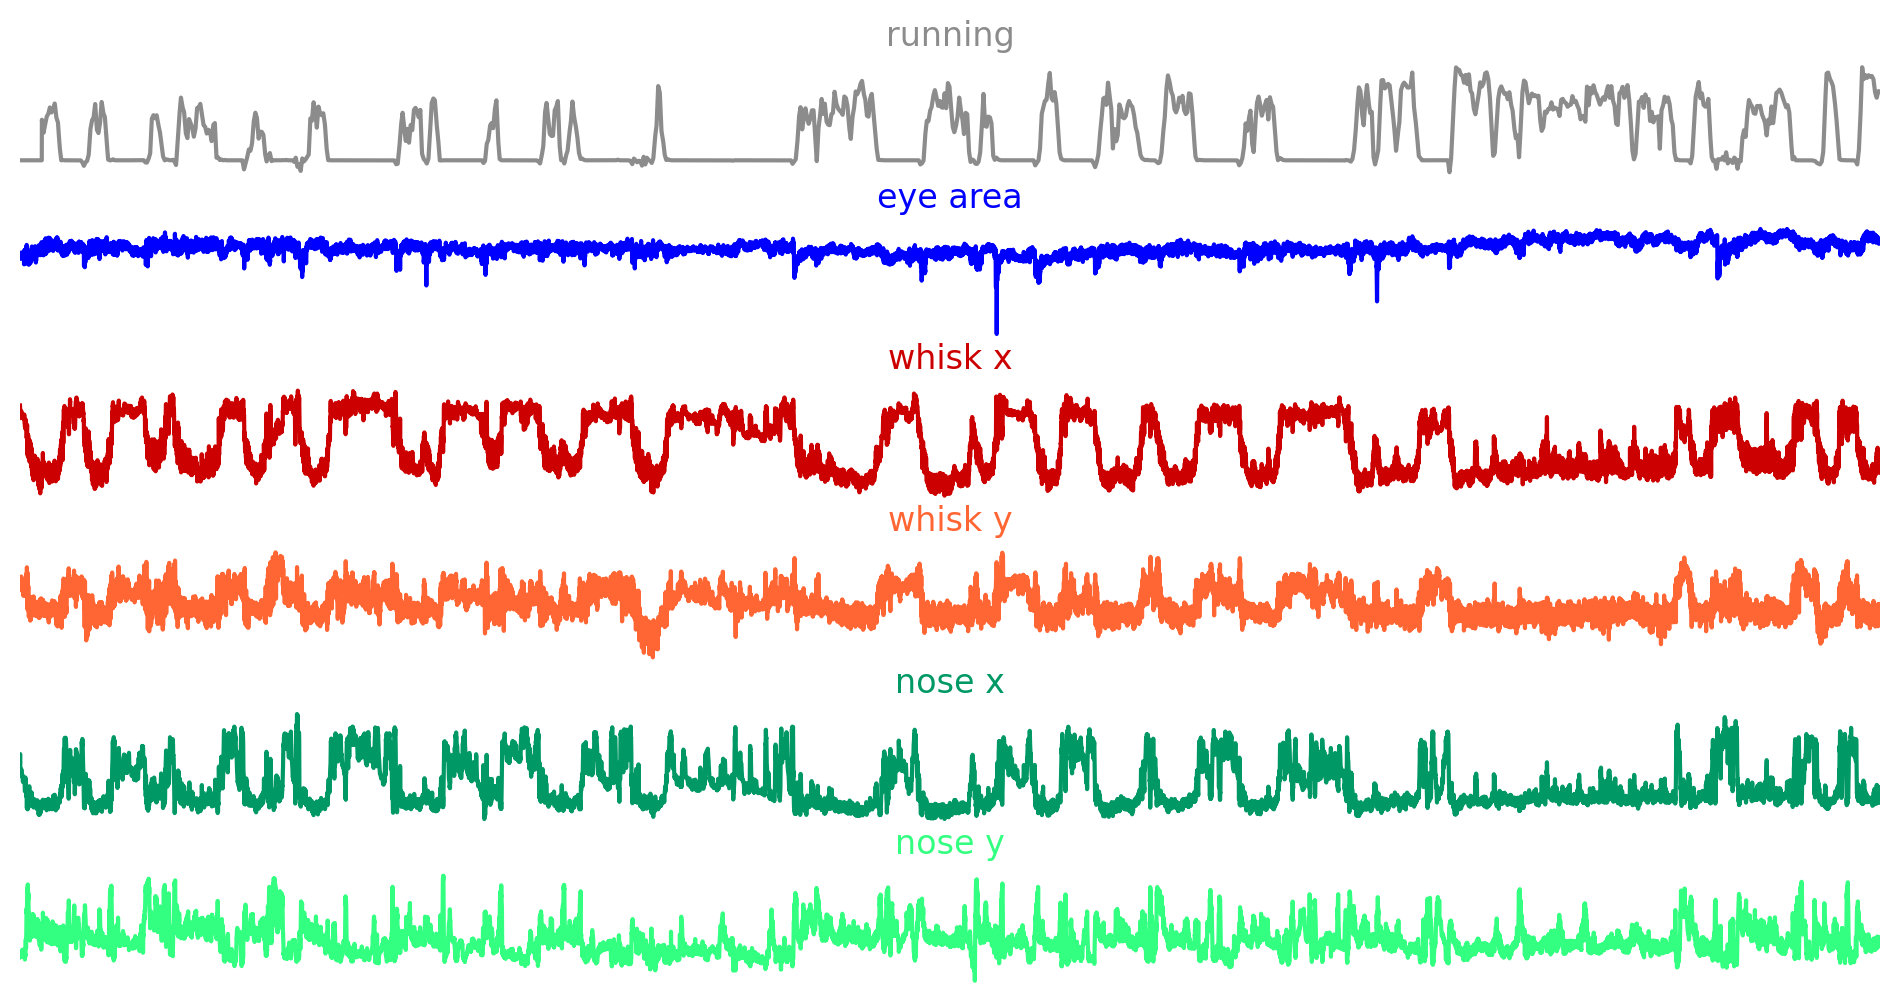

In [64]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(len(beh_names), 1, figure=fig, hspace = 0.4)

n_beh = beh.shape[1]
for j in range(n_beh):
    ax = plt.subplot(grid[j])
    ax.plot(beh[17*xmin:17*xmax, j], color=kp_colors[j])
    ax.set_xlim([0, 17*(xmax-xmin)])
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j])


Since the sampling rate and timing of neural activity and the behavior are different, we will first downsample the behavior data to the timestamps of the neural activity.

The easiest way to do this is with interpolation: we know when in time each behavior frame happened (`tcam`), and then we sample it at each time the neural activity happened (`tneural`). But there are a lot of fast things going on in the behavior, so to get the average over timepoints at the neural activity time, we smooth the behavioral data first.

In [59]:
from scipy.ndimage import gaussian_filter1d # here we import a smoothing function
from scipy.interpolate import interp1d # importing an interpolation function
np.shape(tcam)
# initialize empty matrix
beh_ds = np.zeros((len(tneural), n_beh), "float32")

for j in range(n_beh):
    # filter the data
    # (smoothing scale proportional to difference in sampling rate)
    bsmooth = gaussian_filter1d(beh[:,j], 50/3.2)

    # interpolate
    f = interp1d(tcam, bsmooth)

    # REPLACE ?????
    # look up the usage of interp1d to find out how to apply the function f at new times "tneural"
    beh_ds[:,j] = f(tneural)

print(beh_ds.shape)

(14000, 6)


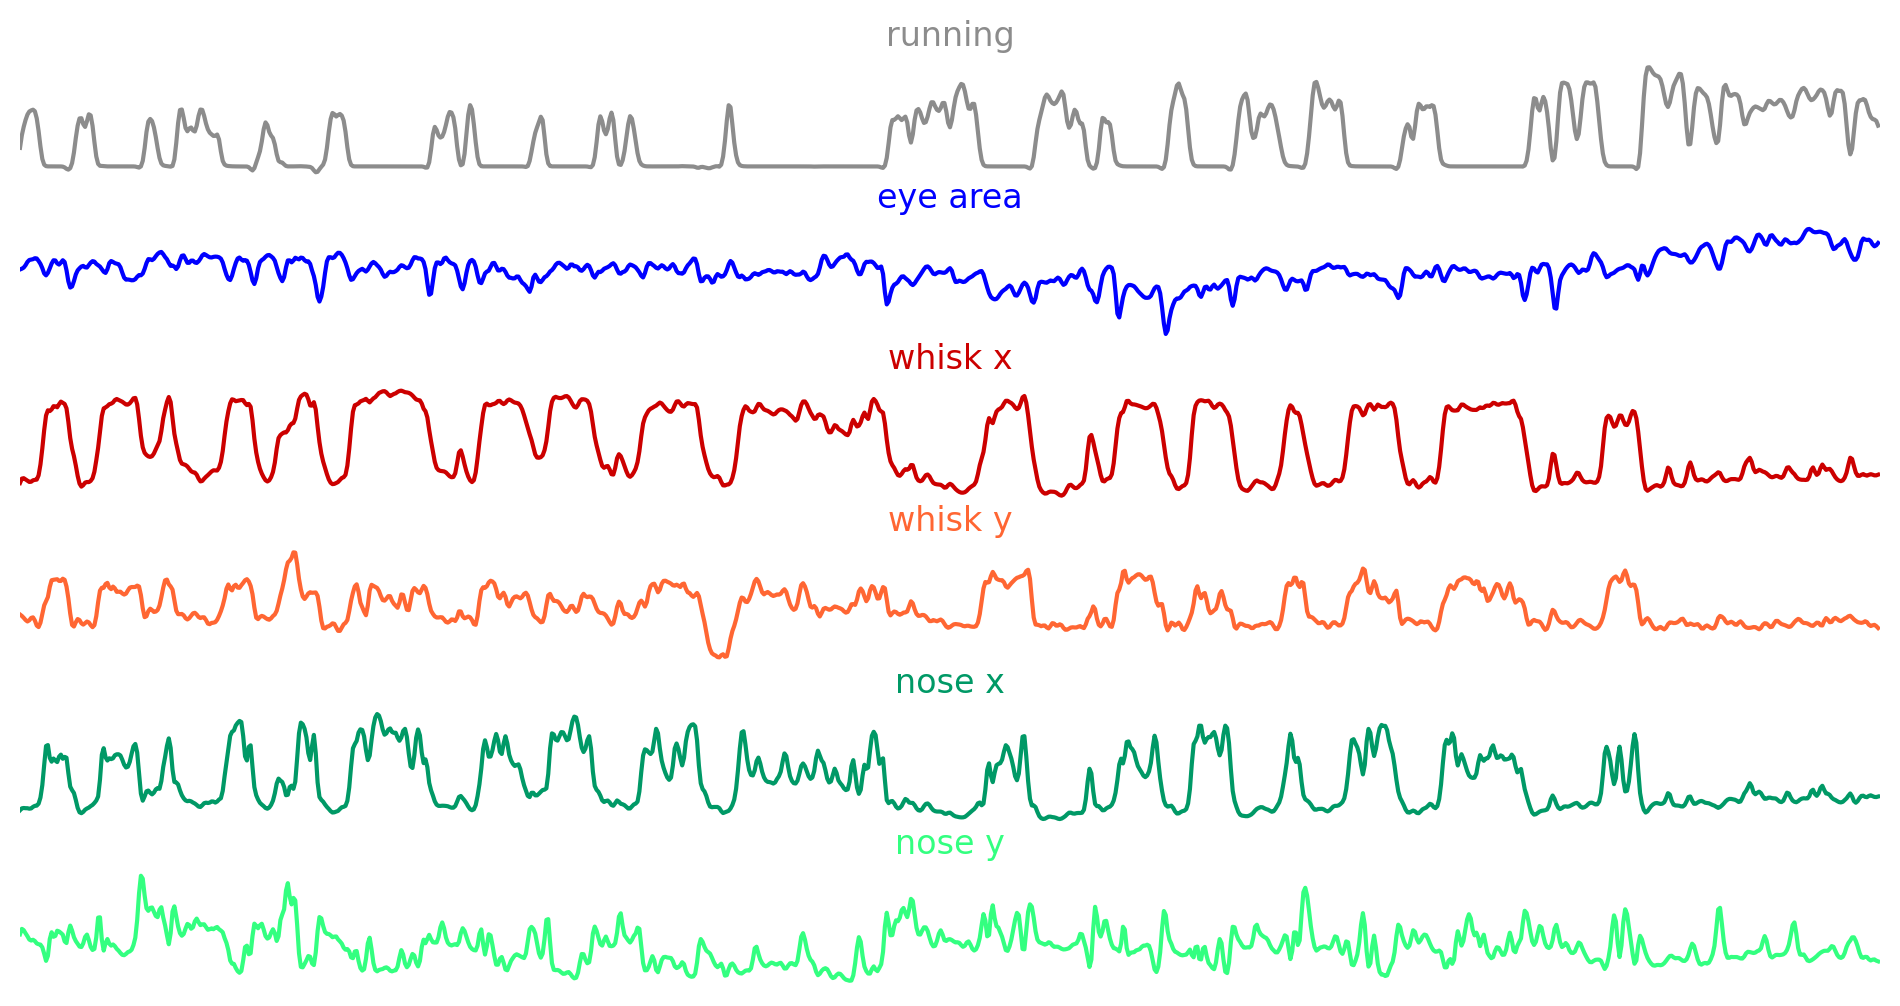

In [62]:
# plot the traces again
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(len(beh_names), 1, figure=fig, hspace = 0.4)
for j in range(n_beh):
    ax = plt.subplot(grid[j])

    # REPLACE ????? to plot the interpolated behaviors from timepoint xmin to timepoint xmax
    ax.plot(beh_ds[xmin:xmax,j], color=kp_colors[j])

    ax.set_xlim([0, (xmax-xmin)])
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j])


Now, to do prediction, we have to do a train-test split. You always want to train your model on a subset of data and test its performance on another set

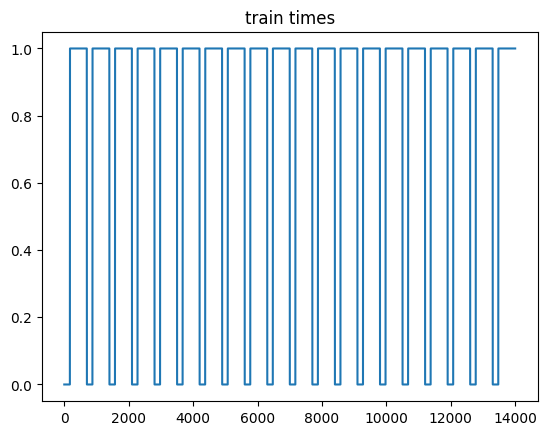

In [61]:
# split into train-test
# * use interleaved segments *
n_segs = 20
n_len  = n_time / n_segs
sinds = np.linspace(0, n_time - n_len, n_segs).astype(int)
itest = (sinds[:,np.newaxis] + np.arange(0, n_len*0.25, 1, int)).flatten()
itrain = np.ones(n_time, "bool")
itrain[itest] = 0
itest = ~itrain

plt.plot(itrain)
plt.title("train times")
plt.show()

In [ ]:
# DISCUSSION:   PLEASE TALK WITH A COLLEAGUE ABOUT WHY THE TRAIN/TEST indices are split in this way.
# Why did we split into segments rather than randomly interleaving time-points?


## Linear regression prediction

Use linear regression to perform the prediction, predict PCs $Y$ using behaviors $X$:

$$ A = (X_\text{train}^\top X_\text{train})^{-1} (X_\text{train}^\top Y_\text{train})$$

$X$ is behavioral components by time, $Y$ is neural components by time. If you want to regularize the linear regression:

$$ A = (X_\text{train}^\top X_\text{train} + \lambda I)^{-1} (X_\text{train}^\top Y_\text{train})$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = X_\text{test} A $$

In [ ]:
## predict using behavior traces
# regularized linear regression from behavior to neural PCs

XtX = beh_ds[itrain].T @ beh_ds[itrain]
XtY = beh_ds[itrain].T @ Vsv[itrain]
lam = 1e1 # regularizer

# REPLACE ?????
# add a ridge regularizer to the linear regression with parameter "lam"
# HINT: look up the function "np.eye"
XtX = XtX + ?????

# regression matrix
A = np.linalg.solve(XtX, XtY)

# prediction on test data, REPLACE ????? with behaviors on test points and the regression matrix
Vpred = ????? @ ?????

# variance explained per PC
residual = ((Vpred - Vsv[itest])**2).sum(axis=0)
varexp_PC = 1 - residual / (Vsv[itest]**2).sum(axis=0)

# overall varexp
varexp = 1 - residual.sum() / (Vsv[itest]**2).sum()

print(f"overall variance explained = {varexp}")

plot PCs and prediction

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(8, 1, figure=fig, hspace = 0.4)

for j in range(8):
    ax = plt.subplot(grid[j])
    ax.plot(Vsv[itest][xmin:xmax, j], color=pc_colors[j])
    ax.plot(Vpred[xmin:xmax, j], color="k", linestyle="--")
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}, varexp = {varexp_PC[j]:.2f}", color=pc_colors[j])
    if j==0:
        ax.legend(["PC", "prediction"], loc="upper right")

In [ ]:
# DISCUSSION: Why is the top PC predicted better? Does that mean something?

## Predicting with a 1D convolution layer

There are finer temportal features in the behavioral features that we aren't capturing by smoothing and using the smoothed traces.

Instead we can learn the temporal features by using a 1D convolution layer with various filters -- called kernels.

See below a nice illustration of a convolution from this [webpage](https://e2eml.school/convolution_one_d.html). This kernel is a gaussian, you can see how it smooths the data. But a neural network can learn whatever kernels help with prediction.

![conv_gif](https://e2eml.school/images/conv1d/stride_1.gif)

We will use **pytorch** for this. It allows us to write a network and then it automatically finds the gradients to optimize it to our data.

We will create a model with a linear input layer, a one-dimensional convolutional layer, and a linear output layer.

In [ ]:
from neuropop import nn_prediction
import torch

# ideally we have a GPU we can use ("cuda" option)
device = torch.device("cuda")

# declare the model
pred_model = nn_prediction.PredictionNetwork(n_in=beh.shape[-1], n_kp=22, identity=False,
                                             n_filt=10, n_latents=0,
                                             n_out=Vsv.shape[-1], n_core_layers=1,
                                             relu_wavelets=False, relu_latents=False)
# put model on the GPU
pred_model.to(device);

print(pred_model)

In [ ]:
# QUIZ: what is the number of linear layers in this network?
# A: <=3
# B: >3 but <=6
# C: >6

In [ ]:
# NOTE: even though there are multiple "layers" in this model, there are no nonlinearities, and thus the model is
# fully linear from end-to-end. This is a form of "reduced rank" regression, that is further factorized across time and space.

You should see the layers, can you figure out what some of these variables mean?

Now let's train the model with a function we have that includes the data splitting and the gradient descent. We will see the variance explained on each iteration.

In [ ]:
y_pred_all, ve_all, itest = pred_model.train_model(beh, Vsv, tcam, tneural, delay=-1,
                                                    learning_rate=1e-3, n_iter=300,
                                                    device=device, verbose=True)
Vpred_conv = y_pred_all
itest = itest.flatten() # we run using batches of data so we now flatten it

# variance explained per PC
residual = ((Vpred_conv - Vsv[itest])**2).sum(axis=0)
varexp_PC_conv = 1 - residual / (Vsv[itest]**2).sum(axis=0)


This fit better! Let's see what the prediction looks like, it seems like the higher PCs are better captured especially.

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(8, 1, figure=fig, hspace = 0.4)

for j in range(8):
    ax = plt.subplot(grid[j])
    ax.plot(Vsv[itest][xmin:xmax, j], color=pc_colors[j])
    ax.plot(Vpred_conv[xmin:xmax, j], color="k", linestyle="--")
    ax.set_xlim([0, xmax-xmin])
    ax.axis("off")
    ax.set_title(f"PC {j+1}, varexp = {varexp_PC_conv[j]:.2f}", color=pc_colors[j])
    if j==0:
        ax.legend(["PC", "prediction"], loc="upper right")

## Receptive fields of superneurons

We can use this linear model to estimate the receptive fields of the superneurons.

First we need to get the superneuron PC weights.

In [ ]:
# sort and bin PCs for maxstim estimation
U_sn = U[isort][:ndiv].reshape(ndiv//nbin, nbin, -1).mean(axis=1)

print(U_sn.shape)

In [ ]:
ms_model = nn_prediction.MaxStimModel(pred_model)
ms_model.requires_grad = False
u = torch.from_numpy(U_sn).to(device)
u.requires_grad = False
xr = ms_model.train_batch(u, n_iter=200, learning_rate=1e-2)
rfs = xr.detach().cpu().numpy()

print(rfs.shape)

Visualize a subset of receptive fields

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(12, 21, figure=fig, wspace = 0.05, hspace = 0.0)

vmax = 8
ks = np.linspace(5, len(U_sn)-5, 12*3).astype("int")
for i, k in enumerate(ks):
    for j in range(n_beh):
        ax = plt.subplot(grid[i%12, j + 6*(i//12) + (i//12)])
        ax.plot(rfs[k, 100:-100, j], color=kp_colors[j])
        ax.set_ylim([-vmax, vmax])
        ax.axis("off")
        if i==0:
            ax.set_title(beh_names[j], color=kp_colors[j], rotation=45)



In [ ]:
# QUIZ:

# The receptive fields are:
# A) a function of a neuron (or group of neurons) which predicts behavior
# B) a function of the principal components which predicts behavior
# C) a function of behavior which matches a neuron (or group of neurons)
# D) a function of behavior which matches a neural principal component

Visualize the receptive fields with the data

In [ ]:
# timepoints to visualize
xmin = 0
xmax = xmin + 1000

fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 18, figure=fig, wspace = 0.35, hspace = 0.3)

# plot running speed
ax = plt.subplot(grid[0, :12])
ax.plot(run[xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:, :12])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

for j in range(n_beh):
    ax = plt.subplot(grid[1:, j+12])
    ax.imshow(rfs[:,100:-100,j], aspect="auto", vmin=-vmax, vmax=vmax, cmap="RdBu_r")
    ax.axis("off")
    ax.set_title(beh_names[j], color=kp_colors[j], rotation=45)


In [ ]:
# DISCUSSION: what does a "receptive field" from behavior mean?
# Is it the same as the receptive field of a sensory neuron, like a Gabor model? How is it similar / different?

## Nonlinear prediction with 1D convolutions

We can put non-linearities in our neural network models to better model non-linear aspects of the data. We also add another layer to make it more complex. The network below is the default network from the Facemap paper.

In [ ]:
pred_model = nn_prediction.PredictionNetwork(n_in=beh.shape[-1], n_kp=22,
                                             n_out=Vsv.shape[-1])
# put model on the GPU
pred_model.to(device);

print(pred_model)

In [ ]:
# QUIZ: what is the number of layers in this network?
# A: <=3
# B: >3 but <=6
# C: >6

Train model

In [ ]:
y_pred_all, ve_all, itest = pred_model.train_model(beh, Vsv, tcam, tneural, delay=-1,
                                                        learning_rate=1e-3, n_iter=400,
                                                    device=device, verbose=True)
Vpred_nl = y_pred_all
itest = itest.flatten() # we run using batches of data so we now flatten it

# variance explained per PC
residual = ((Vpred_nl - Vsv[itest])**2).sum(axis=0)
varexp_PC_nl = 1 - residual / (Vsv[itest]**2).sum(axis=0)

Visualize the prediction. Remember we need to project using the PCs into the neuron space.

In [ ]:
sn_pred = U_sn @ Vpred_nl.T


fig = plt.figure(figsize=(12,12), dpi=200)
grid = plt.GridSpec(13, 1, figure=fig, wspace = 0.35, hspace = 0.6)

# plot running speed
ax = plt.subplot(grid[0, 0])
ax.plot(run[itest][xmin:xmax], color=kp_colors[0])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("running speed", color=kp_colors[0])

# plot superneuron activity
ax = plt.subplot(grid[1:7, 0])
ax.imshow(sn[:, itest][:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.85, aspect="auto")
ax.set_ylabel("superneurons")
ax.set_xticks([])
ax.set_title("neural activity")

# plot superneuron prediction
ax = plt.subplot(grid[7:, 0])
ax.imshow(sn_pred[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.85, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")
ax.set_title("behavior prediction")

In [ ]:
# DISCUSSION: How can I use Rastermap in a scientific paper which requires rigorous quantification?
# All it does is make pretty pictures. Is it even really that useful?